In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [24]:
import os, sys

import experiment_util
import evaluation_util as eva
import evaluation_util
import pandas as pd

from heapq import nsmallest
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import experiment_util as ex2util
from experiment_util import hyper_init_dict
import experiment_models as ex2models

import theano_models as tm
import theano_models.probabilistic_models as pm
from theano.tensor.shared_randomstreams import RandomStreams
from schlichtanders.myobjects import NestedNamespace
from schlichtanders.mydicts import update

import numpy as np

In [25]:
pm.RNG = NestedNamespace(tm.PooledRandomStreams(pool_size=int(1e8)), RandomStreams())

In [26]:
main_folder = os.path.dirname(os.getcwd())

sys.path.append(main_folder)

import experiment1.experiment_util as ex1util
Hypers = ex1util.get_hyper(), ex1util.get_semiold_hyper(), ex1util.get_old_hyper()

# global

In [27]:
Hyper = ex2util.get_hyper()
filepath = os.path.realpath("interactive.db")

In [28]:
datasetnames = ["boston","concrete","energy","powerplant","kin8nm", "winered","yacht"] #, "toy1d","toy2d"]
folders = ["../experiment1/withpercent", '../experiment1/first_useful_hyperparameter_search', '../experiment1/run_windows/']

In [29]:
datasetname = datasetnames[2]
modelname = "planarflowdet"
optimization_type = "annealing"
print datasetname, modelname, optimization_type

energy planarflowdet annealing


# get best parameters / hyper

In [30]:
reload(eva)

<module 'evaluation_util' from '/home/stephan/GitProjects/theano_models/experiment2/__file__'>

In [31]:
best_hyper = eva.get_single_best_hyper(folders, modelname, Hypers=Hypers, attr="best_val_loss", 
                                       key_files=lambda fn, p: datasetname in fn)

In [32]:
print best_hyper.best_val_loss
print best_hyper.best_val_error
print best_hyper.best_parameters
print best_hyper.n_normflows

0.624296210153
0.96217828989
[ -9.00393032e-01  -1.01896164e+00  -9.91373245e-01 ...,  -3.92295364e-03
  -9.29604522e-04   6.06598800e-03]
2


# test runs

In [33]:
data, error_func = ex2util.load_and_preprocess_data(datasetname)
X, Z, VX, VZ, TX, TZ = data

In [34]:
init_dict = {k:v for k, v in best_hyper.__dict__.iteritems() if k[:3] not in ["bas", "pla", "rad", "mix"]}
del init_dict['best_val_loss']
update(init_dict, ex2util.get_init_data(data), overwrite=True)

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7f5a69488250>,
 'batch_size': 10,
 'best_parameters': array([ -9.00393032e-01,  -1.01896164e+00,  -9.91373245e-01, ...,
         -3.92295364e-03,  -9.29604522e-04,   6.06598800e-03]),
 'best_val_error': 0.9621782898902893,
 'datasetname': u'energy',
 'errorrate_average_n': 20,
 'example_input': array([ 0.5281769 , -0.67260158,  0.        , -0.65587896,  1.        ,
        -0.44721359,  1.24405944, -0.52421057], dtype=float32),
 'example_output': array([ 0.71232325], dtype=float32),
 'exp_average_n': 20,
 'exp_ratio_estimator': None,
 'id': 2,
 'init_parameters': array([-0.18207978, -0.05092094,  0.25354495, ..., -0.46847066,
        -0.09905421, -0.47915712]),
 'logP_average_n': 10,
 'max_epochs_without_improvement': 30,
 'minus_log_s1': 4,
 'minus_log_s2': 8,
 'modelname': 'planarflowdet',
 'n_layers': 1,
 'n_normflows': 2,
 'opt_decay': 0.9880436498467586,
 'opt_identifier': u'adam',
 'opt_momentum': 0.00329938253430111

In [35]:
hyper = Hyper(datasetname, modelname, optimization_type="annealing")  #"annealing"
hyper_init_dict(hyper, init_dict)
hyper.annealing_T = 100
hyper.adapt_prior = True
if hyper.adapt_prior:
    hyper.init_parameters = np.r_[hyper.init_parameters, 0]
hyper.max_epochs_without_improvement = 40

if "radial" in modelname:
    hyper.n_normflows = 2*hyper.n_normflows  # compatibility issue

In [36]:
engine = create_engine('sqlite:///' + filepath)  # os.path.join(__path__, foldername, '%s.db' % filename)
Hyper.metadata.create_all(engine)
Session = sessionmaker(bind=engine)
sql_session = Session()

<IPython.core.display.Javascript object>


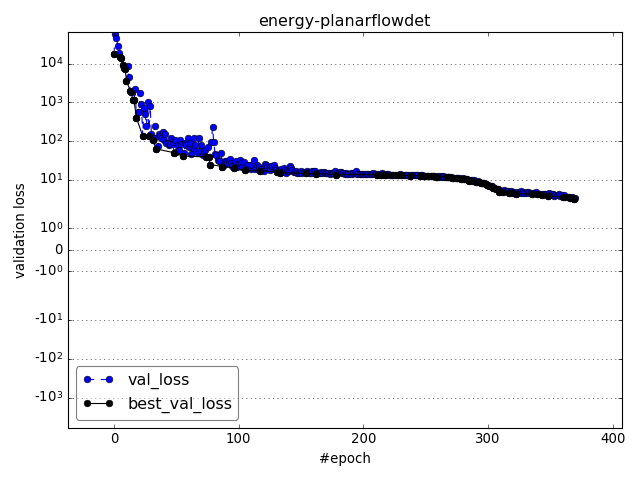

In [ ]:
plt.figure()
h_val = plt.plot([],[], color='blue', linestyle='dashed', marker='o', label="val_loss")[0]
h_best_val = plt.plot([], [], color='black', linestyle='solid', marker='o', label="best_val_loss")[0]
plt.yscale('symlog')
# plt.tick_params(axis='y', which='minor')
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%.1g"))
# plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2g"))
plt.gca().yaxis.grid(True)
plt.ylabel("validation loss")
plt.xlabel("#epoch")
plt.title("%s-%s" % (datasetname, modelname))
plt.legend(loc='lower left', fancybox=True, framealpha=0.5)

In [ ]:
model_creator = getattr(ex2models, modelname)
model, approx_posterior = model_creator(hyper)

ex2util.optimize(data, hyper, model, error_func, plot_val=h_val, plot_best_val=h_best_val)

normalizing flow annealing
used given init_parameters
batch_precompile
batch_precompile
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 

In [ ]:
hyper.best_test_loss

In [ ]:
hyper.best_val_loss

In [ ]:
hyper.best_test_error